# Mount Google Drive if running on Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences

Deepfakes  Face2Face  FaceSwap	NeuralTextures


# Deepfake Detection Analysis & XAI

This notebook consolidates model loading, inference, and Explainable AI (XAI) analysis.
It implements **GradCAM** and **LIME** to visualize which parts of the image contribute to the deepfake detection decision.

**Author:** Team Member 3 (Analysis & Detection)

## Contents
1. Setup & Dependencies
2. Model Architecture
3. Preprocessing Pipeline
4. XAI Methods (GradCAM, LIME)
5. Visualization Utilities
6. Single Image Analysis
7. Batch Analysis & Comparison
8. Results Export


In [3]:
# Install required packages
%pip install torch torchvision timm opencv-python matplotlib pillow lime numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3f05224ec1b8a663813e3ed8473dc9ca866390abe630ca1e415e14e2b4bf36ae
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [4]:
# Cell 1: Setup & Dependencies
import os
import json
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms.functional import to_pil_image
import timm
from abc import ABC, abstractmethod
from pathlib import Path
from typing import List, Tuple, Optional, Dict
import warnings
warnings.filterwarnings('ignore')

# Check for CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Project paths
# PROJECT_ROOT = Path("../").resolve()
PROJECT_ROOT = Path("/content/").resolve() # for colab
print(f"Project root: {PROJECT_ROOT}")


Using device: cuda
Project root: /content


In [38]:
# =============================================================================
# MODEL CONFIGURATION
# =============================================================================
# Set MODEL_TYPE to switch between architectures:
#   - "efficientnet": EfficientNet-B0 (3-class: Real, FaceSwap, Face2Face)
#   - "vit_supcon": ViT-Base with SupCon training (5-class: Real, Deepfakes, Face2Face, FaceSwap, NeuralTextures)
# =============================================================================

MODEL_TYPE = "vit_supcon"  # OPTIONS: "efficientnet" or "vit_supcon"

# Configuration for EfficientNet model
EFFICIENTNET_CONFIG = {
    "num_classes": 3,
    "backbone_name": "efficientnet_b0",
    "imagenet_mean": [0.485, 0.456, 0.406],
    "imagenet_std": [0.229, 0.224, 0.225],
    "class_names": ["Real", "FaceSwap", "Face2Face"],
    "input_size": (224, 224),
}

# Configuration for ViT SupCon model
VIT_SUPCON_CONFIG = {
    "num_classes": 5,
    "backbone_name": "vit_base_patch16_224",
    "imagenet_mean": [0.485, 0.456, 0.406],
    "imagenet_std": [0.229, 0.224, 0.225],
    "class_names": ["Real", "Deepfakes", "Face2Face", "FaceSwap", "NeuralTextures"],
    "input_size": (224, 224),
}

# Select config based on MODEL_TYPE
CONFIG = VIT_SUPCON_CONFIG if MODEL_TYPE == "vit_supcon" else EFFICIENTNET_CONFIG

NUM_CLASSES = CONFIG["num_classes"]
BACKBONE_NAME = CONFIG["backbone_name"]
IMAGENET_MEAN = CONFIG["imagenet_mean"]
IMAGENET_STD = CONFIG["imagenet_std"]
CLASS_NAMES = CONFIG["class_names"]

print(f"Model Type: {MODEL_TYPE}")
print(f"Configuration loaded:")
print(f"  Classes: {CLASS_NAMES}")
print(f"  Backbone: {BACKBONE_NAME}")


Model Type: vit_supcon
Configuration loaded:
  Classes: ['Real', 'Deepfakes', 'Face2Face', 'FaceSwap', 'NeuralTextures']
  Backbone: vit_base_patch16_224


## 2. Model Architecture

EfficientNet-based deepfake classifier using the `timm` library.


In [39]:
# =============================================================================
# MODEL ARCHITECTURES
# =============================================================================

class EfficientNetDeepfake(nn.Module):
    """
    EfficientNet-based deepfake classifier.
    Uses timm library for the backbone.
    """
    def __init__(self, num_classes: int = 3, backbone_name: str = "efficientnet_b0"):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=False,
            num_classes=0,  # Remove classification head
            in_chans=3,
        )
        # Get feature dimension dynamically
        if hasattr(self.backbone, "num_features"):
            feat_dim = self.backbone.num_features
        elif hasattr(self.backbone, "classifier") and hasattr(self.backbone.classifier, "in_features"):
            feat_dim = self.backbone.classifier.in_features
        else:
            feat_dim = 1280  # Default for efficientnet_b0

        self.classifier = nn.Linear(feat_dim, num_classes)
        self.feat_dim = feat_dim

    def forward(self, x):
        feats = self.backbone(x)
        logits = self.classifier(feats)
        return logits

    def get_features(self, x):
        """Get feature embeddings without classification."""
        return self.backbone(x)


class ViTEncoder(nn.Module):
    """
    Vision Transformer encoder wrapper for SupCon-trained models.
    - Loads a timm ViT with num_classes=0 → returns CLS embedding.
    - Stores embedding dimension for projection head & classifier.
    - Allows selective fine-tuning of last N transformer blocks.
    """
    def __init__(self, model_name: str = "vit_base_patch16_224", pretrained: bool = False):
        super().__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0   # return CLS embedding (pooled)
        )
        self.embed_dim = getattr(self.backbone, "num_features", 768)
        self.depth = len(getattr(self.backbone, "blocks", [])) if hasattr(self.backbone, "blocks") else 12

    def freeze_all(self):
        """Freeze entire encoder (used before linear-probe training)."""
        for p in self.parameters():
            p.requires_grad = False

    def unfreeze_last_blocks(self, num_blocks: int = 2):
        """Unfreeze last N transformer blocks + final norm."""
        self.freeze_all()
        start = max(0, self.depth - num_blocks)
        for name, param in self.backbone.named_parameters():
            if any(f"blocks.{i}." in name for i in range(start, self.depth)):
                param.requires_grad = True
            if "norm." in name or "fc_norm." in name:
                param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)


class AttributionModel(nn.Module):
    """
    ViT Encoder + Linear Classifier for deepfake attribution.
    Used with SupCon pre-trained encoder.
    """
    def __init__(self, encoder: ViTEncoder, num_classes: int = 5):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.embed_dim, num_classes)
        self.feat_dim = encoder.embed_dim  # For compatibility

    def forward(self, x):
        feats = self.encoder(x)
        logits = self.classifier(feats)
        return logits

    def get_features(self, x):
        """Get feature embeddings without classification."""
        return self.encoder(x)


print("Model classes defined: EfficientNetDeepfake, ViTEncoder, AttributionModel")


Model classes defined: EfficientNetDeepfake, ViTEncoder, AttributionModel


## 3. Preprocessing Pipeline


In [40]:
def get_eval_transform(model_type: str = MODEL_TYPE):
    """
    Get evaluation transform based on model type.
    - EfficientNet: Resize(256) + CenterCrop(224) + Normalize
    - ViT SupCon: Resize(224) + Normalize (no center crop, matches training)
    """
    if model_type == "vit_supcon":
        # ViT SupCon training used direct resize without center crop
        return T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ])
    else:
        # EfficientNet standard preprocessing
        return T.Compose([
            T.Resize((256, 256)),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ])

def load_image(path: str) -> Image.Image:
    """Load an image from path."""
    return Image.open(path).convert("RGB")

def preprocess_image(image: Image.Image) -> torch.Tensor:
    """Preprocess a PIL image for model input."""
    transform = get_eval_transform()
    return transform(image).unsqueeze(0)

def denormalize(tensor: torch.Tensor) -> np.ndarray:
    """Convert normalized tensor back to displayable image."""
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
    # Detach from graph before processing to avoid 'requires_grad' errors
    tensor = tensor.detach().cpu().clone()
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return (tensor.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8)

print(f"Preprocessing functions defined (using {MODEL_TYPE} transforms).")

Preprocessing functions defined (using vit_supcon transforms).


## 4. XAI Methods

### Base Explainer Class


In [41]:
class BaseExplainer(ABC):
    """
    Abstract base class for all explanation methods.
    """
    def __init__(self, model: nn.Module, device: str = 'cpu'):
        self.model = model
        self.device = device
        self.model.to(self.device)
        self.model.eval()

    @abstractmethod
    def explain(self, input_tensor: torch.Tensor, target_class: int = None) -> np.ndarray:
        """Generate explanation heatmap."""
        pass

    def predict(self, input_tensor: torch.Tensor) -> Tuple[int, np.ndarray]:
        """Get prediction and probabilities."""
        with torch.no_grad():
            logits = self.model(input_tensor.to(self.device))
            probs = F.softmax(logits, dim=1)[0].cpu().numpy()
            pred_class = int(probs.argmax())
        return pred_class, probs

print("BaseExplainer class defined.")


BaseExplainer class defined.


### GradCAM Explainer

Gradient-weighted Class Activation Mapping highlights regions that contribute most to the prediction.


In [42]:
class GradCAMExplainer(BaseExplainer):
    """
    Gradient-weighted Class Activation Mapping (GradCAM).
    Highlights regions that contribute most to the prediction.

    Supports both CNN (EfficientNet) and Transformer (ViT) architectures.
    """
    def __init__(self, model: nn.Module, target_layer: nn.Module, device: str = 'cpu',
                 model_type: str = "efficientnet"):
        super().__init__(model, device)
        self.target_layer = target_layer
        self.model_type = model_type
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def explain(self, input_tensor: torch.Tensor, target_class: int = None) -> np.ndarray:
        """
        Compute GradCAM heatmap.

        Args:
            input_tensor: Preprocessed image tensor (1, C, H, W)
            target_class: Class index to explain (default: predicted class)

        Returns:
            Normalized heatmap (H, W) in range [0, 1]
        """
        input_tensor = input_tensor.to(self.device)
        input_tensor.requires_grad = True

        # Forward pass
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        score = output[0, target_class]
        score.backward()

        # Compute GradCAM - handle different architectures
        if self.model_type == "vit_supcon":
            # ViT: activations shape is [B, num_patches+1, embed_dim]
            # We need to reshape to spatial format
            # For ViT-Base with patch_size=16 and 224x224 input: 14x14 = 196 patches + 1 CLS token

            # Remove CLS token (first token) and reshape to spatial
            # activations: [1, 197, 768] -> [1, 196, 768] -> [1, 768, 14, 14]
            acts = self.activations[:, 1:, :]  # Remove CLS token
            grads = self.gradients[:, 1:, :]  # Remove CLS token

            num_patches = acts.shape[1]
            h = w = int(num_patches ** 0.5)  # 14 for 224x224 with patch_size=16

            # Reshape to spatial: [B, num_patches, embed_dim] -> [B, embed_dim, H, W]
            acts = acts.permute(0, 2, 1).reshape(1, -1, h, w)
            grads = grads.permute(0, 2, 1).reshape(1, -1, h, w)

            # Standard GradCAM computation
            weights = torch.mean(grads, dim=(2, 3), keepdim=True)
            cam = torch.sum(weights * acts, dim=1, keepdim=True)
        else:
            # CNN: activations shape is [B, C, H, W]
            weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
            cam = torch.sum(weights * self.activations, dim=1, keepdim=True)

        cam = F.relu(cam)

        # Resize to input size
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()

        # Normalize
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam

print("GradCAMExplainer class defined (supports EfficientNet & ViT).")


GradCAMExplainer class defined (supports EfficientNet & ViT).


### LIME Explainer

Local Interpretable Model-agnostic Explanations - explains predictions by learning local surrogate models.


In [43]:
class LIMEExplainer(BaseExplainer):
    """
    Local Interpretable Model-agnostic Explanations (LIME).
    Explains predictions by learning local surrogate models.
    """
    def __init__(self, model: nn.Module, device: str = 'cpu', num_samples: int = 1000):
        super().__init__(model, device)
        self.num_samples = num_samples
        self.explainer = None

        try:
            from lime import lime_image
            self.explainer = lime_image.LimeImageExplainer()
            print("LIME initialized successfully.")
        except ImportError:
            print("Warning: LIME not installed. Run `pip install lime`.")

    def _batch_predict(self, images: np.ndarray) -> np.ndarray:
        """Prediction function for LIME."""
        # images: (N, H, W, C) numpy array in [0, 255]
        transform = get_eval_transform()
        batch = []
        for img in images:
            pil_img = Image.fromarray(img.astype(np.uint8))
            batch.append(transform(pil_img))

        batch_tensor = torch.stack(batch).to(self.device)

        with torch.no_grad():
            logits = self.model(batch_tensor)
            probs = F.softmax(logits, dim=1).cpu().numpy()

        return probs

    def explain(self, input_tensor: torch.Tensor, target_class: int = None) -> np.ndarray:
        """
        Compute LIME explanation.

        Args:
            input_tensor: Preprocessed image tensor (1, C, H, W)
            target_class: Class index to explain (default: predicted class)

        Returns:
            Heatmap (H, W) showing feature importance
        """
        if self.explainer is None:
            print("LIME not available. Returning empty heatmap.")
            return np.zeros((224, 224))

        # Convert tensor to numpy image
        image_np = denormalize(input_tensor)

        # Get prediction if target_class not specified
        if target_class is None:
            target_class, _ = self.predict(input_tensor)

        # Run LIME
        explanation = self.explainer.explain_instance(
            image_np,
            self._batch_predict,
            top_labels=NUM_CLASSES,
            hide_color=0,
            num_samples=self.num_samples,
        )

        # Get heatmap for target class
        _, mask = explanation.get_image_and_mask(
            target_class,
            positive_only=False,
            num_features=10,
            hide_rest=False,
        )

        # Normalize mask
        mask = mask.astype(np.float32)
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)

        return mask

print("LIMEExplainer class defined.")


LIMEExplainer class defined.


## 5. Visualization Utilities


In [44]:
def apply_heatmap(image: np.ndarray, heatmap: np.ndarray,
                  alpha: float = 0.5, colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """
    Overlay heatmap on image.

    Args:
        image: Original image (H, W, 3) in [0, 255]
        heatmap: Heatmap (H, W) in [0, 1]
        alpha: Opacity of heatmap overlay
        colormap: OpenCV colormap

    Returns:
        Blended image
    """
    if heatmap.shape[:2] != image.shape[:2]:
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    heatmap_uint8 = (heatmap * 255).astype(np.uint8)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

def plot_single_explanation(image: np.ndarray, heatmap: np.ndarray,
                            title: str = "Explanation", pred_info: str = None):
    """Plot original image, heatmap, and overlay side by side."""
    overlay = apply_heatmap(image, heatmap)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis('off')

    im = axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title("Heatmap")
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis('off')

    if pred_info:
        fig.suptitle(f"{title}\n{pred_info}", fontsize=12)
    else:
        fig.suptitle(title, fontsize=12)

    plt.tight_layout()
    plt.show()

def plot_method_comparison(image: np.ndarray, heatmaps: Dict[str, np.ndarray],
                           pred_info: str = None, save_path: str = None):
    """
    Compare multiple XAI methods side by side.

    Args:
        image: Original image
        heatmaps: Dict mapping method name to heatmap
        pred_info: Prediction info string
        save_path: Optional path to save the figure
    """
    n_methods = len(heatmaps)
    fig, axes = plt.subplots(2, n_methods + 1, figsize=(4 * (n_methods + 1), 8))

    # Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original", fontsize=12)
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')

    # Each method
    for i, (method_name, heatmap) in enumerate(heatmaps.items(), 1):
        # Heatmap
        im = axes[0, i].imshow(heatmap, cmap='jet')
        axes[0, i].set_title(f"{method_name}\nHeatmap", fontsize=12)
        axes[0, i].axis('off')

        # Overlay
        overlay = apply_heatmap(image, heatmap)
        axes[1, i].imshow(overlay)
        axes[1, i].set_title(f"{method_name}\nOverlay", fontsize=12)
        axes[1, i].axis('off')

    if pred_info:
        fig.suptitle(pred_info, fontsize=14, fontweight='bold')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to {save_path}")

    plt.show()

def plot_prediction_bars(probs: np.ndarray, class_names: List[str] = CLASS_NAMES):
    """Plot prediction probabilities as a bar chart."""
    colors = ['green' if i == probs.argmax() else 'steelblue' for i in range(len(probs))]

    plt.figure(figsize=(8, 4))
    bars = plt.bar(class_names, probs, color=colors, edgecolor='black')
    plt.ylabel("Probability", fontsize=12)
    plt.xlabel("Class", fontsize=12)
    plt.title("Prediction Probabilities", fontsize=14)
    plt.ylim(0, 1)

    # Add value labels
    for bar, prob in zip(bars, probs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{prob:.3f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

print("Visualization functions defined.")


Visualization functions defined.


## 6. Model Loading & Initialization


In [45]:
# =============================================================================
# MODEL LOADING
# =============================================================================
# Configure paths based on MODEL_TYPE

if MODEL_TYPE == "vit_supcon":
    # ViT SupCon model checkpoint (contains encoder_state_dict + classifier_state_dict)
    MODEL_PATH = Path("/content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind" + "/" + "models" + "/" + "classifier_finetune_last.pth")
else:
    # EfficientNet model checkpoint (simple state_dict)
    MODEL_PATH = Path("/content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind" + "/" + "models" + "/" + "efficientnet_3class.pth")

print(f"Model type: {MODEL_TYPE}")
print(f"Looking for checkpoint at: {MODEL_PATH}")

# Initialize model based on type
if MODEL_TYPE == "vit_supcon":
    encoder = ViTEncoder(model_name=BACKBONE_NAME, pretrained=False)
    model = AttributionModel(encoder, num_classes=NUM_CLASSES).to(DEVICE)
else:
    model = EfficientNetDeepfake(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME).to(DEVICE)

# Load weights if available
if MODEL_PATH.exists():
    checkpoint = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True)

    if MODEL_TYPE == "vit_supcon":
        # ViT SupCon checkpoint format: nested dict with encoder_state_dict + classifier_state_dict
        if isinstance(checkpoint, dict) and "encoder_state_dict" in checkpoint:
            model.encoder.load_state_dict(checkpoint["encoder_state_dict"])
            model.classifier.load_state_dict(checkpoint["classifier_state_dict"])
            print(f"✓ ViT SupCon model loaded from {MODEL_PATH}")
            if "val_f1" in checkpoint:
                print(f"  Checkpoint val_f1: {checkpoint['val_f1']:.4f}")
        else:
            raise ValueError("Invalid ViT SupCon checkpoint format. Expected 'encoder_state_dict' and 'classifier_state_dict' keys.")
    else:
        # EfficientNet checkpoint format: simple state_dict
        model.load_state_dict(checkpoint)
        print(f"✓ EfficientNet model loaded from {MODEL_PATH}")
else:
    print(f"✗ Model not found at {MODEL_PATH}")
    print("  Using random weights for demonstration.")

model.eval()
print(f"\nModel architecture: {BACKBONE_NAME}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Feature dimension: {model.feat_dim}")


Model type: vit_supcon
Looking for checkpoint at: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/models/classifier_finetune_last.pth
✓ ViT SupCon model loaded from /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/models/classifier_finetune_last.pth
  Checkpoint val_f1: 0.1675

Model architecture: vit_base_patch16_224
Number of classes: 5
Feature dimension: 768


In [46]:
# =============================================================================
# INITIALIZE EXPLAINERS
# =============================================================================
# GradCAM requires a target layer - this differs by architecture:
# - EfficientNet: conv_head (last conv layer before pooling)
# - ViT: Last transformer block's normalization layer

if MODEL_TYPE == "vit_supcon":
    # For ViT, use the last transformer block's norm layer
    # This captures attention patterns in the final representation
    target_layer = model.encoder.backbone.blocks[-1].norm1
    print(f"GradCAM target layer (ViT): blocks[-1].norm1")
else:
    # For EfficientNet, use the last convolutional layer
    target_layer = model.backbone.conv_head
    print(f"GradCAM target layer (EfficientNet): conv_head")

print(f"Target layer type: {type(target_layer).__name__}")

# Initialize explainers with model_type for proper gradient handling
gradcam_explainer = GradCAMExplainer(
    model,
    target_layer=target_layer,
    device=DEVICE,
    model_type=MODEL_TYPE
)
lime_explainer = LIMEExplainer(model, device=DEVICE, num_samples=500)  # Reduce for speed

print("\n✓ Explainers initialized")


GradCAM target layer (ViT): blocks[-1].norm1
Target layer type: LayerNorm
LIME initialized successfully.

✓ Explainers initialized


## 7. Single Image Analysis


In [47]:
def analyze_image(image_path: str, run_lime: bool = False):
    """
    Complete analysis pipeline for a single image.

    Args:
        image_path: Path to the image file
        run_lime: Whether to run LIME (slower)
    """
    print(f"Analyzing: {image_path}")
    print("=" * 50)

    # Load and preprocess
    img = load_image(image_path)
    input_tensor = preprocess_image(img).to(DEVICE)
    display_img = denormalize(input_tensor)

    # Get prediction
    pred_class, probs = gradcam_explainer.predict(input_tensor)
    pred_label = CLASS_NAMES[pred_class]
    confidence = probs[pred_class]

    print(f"\nPrediction: {pred_label}")
    print(f"Confidence: {confidence:.4f}")
    print(f"\nAll probabilities:")
    for name, prob in zip(CLASS_NAMES, probs):
        marker = "←" if name == pred_label else ""
        print(f"  {name}: {prob:.4f} {marker}")

    # Plot prediction bars
    plot_prediction_bars(probs)

    # Generate explanations
    heatmaps = {}

    print("\nGenerating GradCAM...")
    heatmaps["GradCAM"] = gradcam_explainer.explain(input_tensor, target_class=pred_class)

    if run_lime:
        print("Generating LIME (this may take a minute)...")
        heatmaps["LIME"] = lime_explainer.explain(input_tensor, target_class=pred_class)

    # Plot comparison
    pred_info = f"Prediction: {pred_label} ({confidence:.2%})"
    plot_method_comparison(display_img, heatmaps, pred_info=pred_info)

    return pred_class, probs, heatmaps


Selected classification class: Face2Face
Analyzing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Face2Face/c23/026_012.mp4/00282_0.png

Prediction: NeuralTextures
Confidence: 0.4846

All probabilities:
  Real: 0.0849 
  Deepfakes: 0.2024 
  Face2Face: 0.1891 
  FaceSwap: 0.0389 
  NeuralTextures: 0.4846 ←


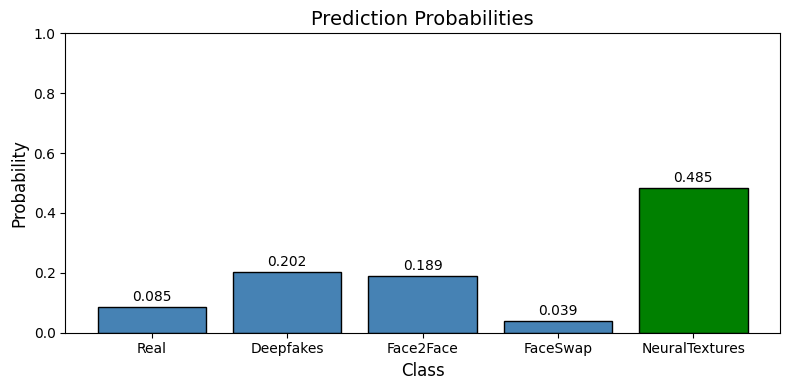


Generating GradCAM...
Generating LIME (this may take a minute)...


  0%|          | 0/500 [00:00<?, ?it/s]

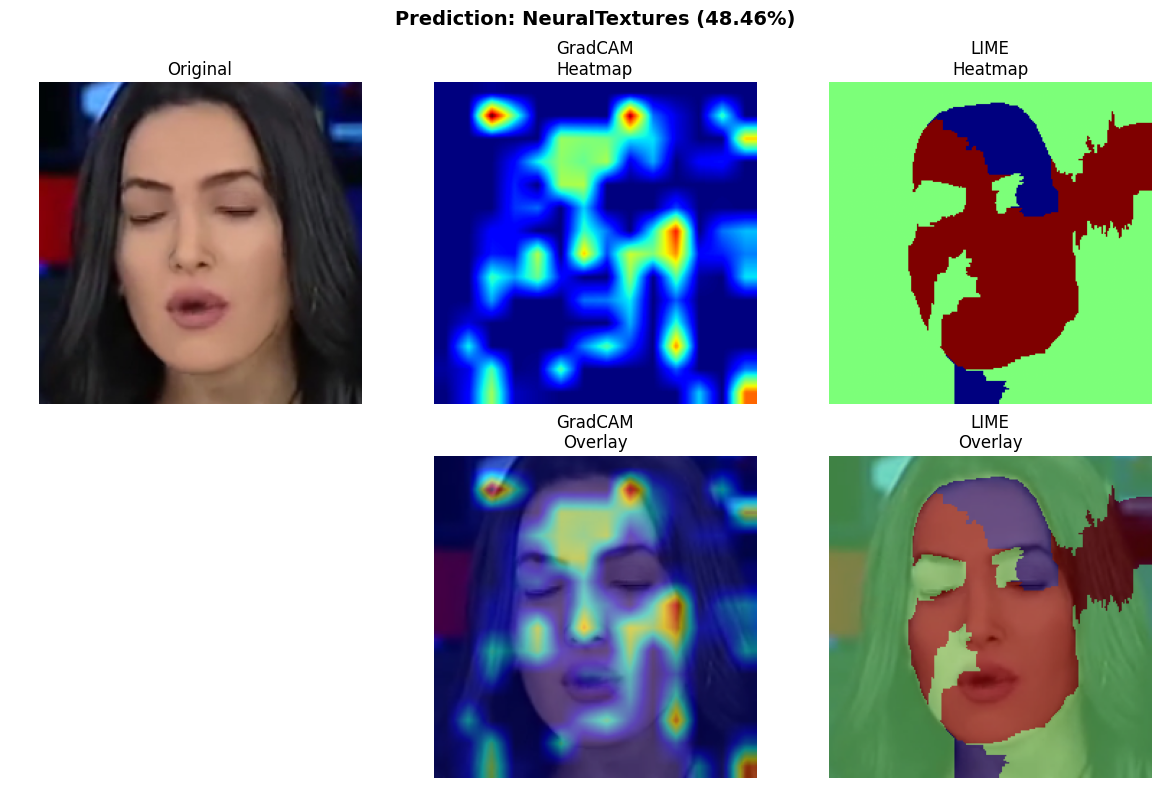

In [48]:
import random

### Colab ###
classes = ["FaceSwap", "Face2Face", "Deepfakes", "NeuralTextures"]
# class_idx = random.randint(0, len(classes) - 1)
class_idx = 1
print(f"Selected classification class: {classes[class_idx]}")
DATA_PATH = f"/content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/{classes[class_idx]}/c23"

# list all directories inside data dir and save them to an array
videos_dirs = os.listdir(DATA_PATH)

video_idx = random.randint(0, len(videos_dirs) - 1)
frames_per_video = os.listdir(DATA_PATH + "/" + videos_dirs[video_idx])
frame_idx = random.randint(0, len(frames_per_video) - 1)
image_path = DATA_PATH + "/" + videos_dirs[video_idx] + "/" + frames_per_video[frame_idx]
####

results = analyze_image(image_path, run_lime=True)


## 8. Batch Analysis


In [49]:
def batch_analyze(image_paths: List[str], output_dir: str = None, run_lime: bool = False):
    """
    Analyze multiple images and collect results.

    Args:
        image_paths: List of image file paths
        output_dir: Directory to save visualization results
        run_lime: Whether to run LIME analysis

    Returns:
        List of result dictionaries
    """
    results = []

    if output_dir:
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)

    for i, img_path in enumerate(image_paths):
        print(f"\n[{i+1}/{len(image_paths)}] Processing: {img_path}")

        try:
            img = load_image(img_path)
            input_tensor = preprocess_image(img).to(DEVICE)
            display_img = denormalize(input_tensor)

            # Prediction
            pred_class, probs = gradcam_explainer.predict(input_tensor)

            # GradCAM
            gradcam_heatmap = gradcam_explainer.explain(input_tensor, target_class=pred_class)

            # LIME (optional)
            lime_heatmap = None
            if run_lime:
                lime_heatmap = lime_explainer.explain(input_tensor, target_class=pred_class)

            result = {
                'image_path': img_path,
                'prediction': CLASS_NAMES[pred_class],
                'confidence': probs[pred_class],
                'probabilities': probs.tolist(),
                'gradcam_heatmap': gradcam_heatmap,
                'lime_heatmap': lime_heatmap,
            }
            results.append(result)

            # Save visualization
            if output_dir:
                heatmaps = {'GradCAM': gradcam_heatmap}
                if lime_heatmap is not None:
                    heatmaps['LIME'] = lime_heatmap

                save_path = output_path / f"analysis_{i:03d}.png"
                pred_info = f"{CLASS_NAMES[pred_class]} ({probs[pred_class]:.2%})"
                plot_method_comparison(display_img, heatmaps, pred_info=pred_info,
                                       save_path=str(save_path))
                plt.close()

        except Exception as e:
            print(f"  Error: {e}")
            results.append({'image_path': img_path, 'error': str(e)})

    print(f"\n✓ Processed {len(results)} images")
    return results

print("Batch analysis function defined.")


Batch analysis function defined.


In [50]:
def summarize_results(results: List[dict]):
    """Print summary statistics from batch analysis."""
    valid_results = [r for r in results if 'error' not in r]

    if not valid_results:
        print("No valid results to summarize.")
        return

    print("\n" + "=" * 50)
    print("BATCH ANALYSIS SUMMARY")
    print("=" * 50)
    print(f"Total images: {len(results)}")
    print(f"Successfully analyzed: {len(valid_results)}")
    print(f"Errors: {len(results) - len(valid_results)}")

    # Class distribution
    class_counts = {name: 0 for name in CLASS_NAMES}
    confidences = []

    for r in valid_results:
        class_counts[r['prediction']] += 1
        confidences.append(r['confidence'])

    print(f"\nPrediction Distribution:")
    for name, count in class_counts.items():
        pct = count / len(valid_results) * 100
        print(f"  {name}: {count} ({pct:.1f}%)")

    print(f"\nConfidence Statistics:")
    print(f"  Mean: {np.mean(confidences):.4f}")
    print(f"  Min:  {np.min(confidences):.4f}")
    print(f"  Max:  {np.max(confidences):.4f}")
    print(f"  Std:  {np.std(confidences):.4f}")

print("Summary function defined.")


Summary function defined.


## 9. Results Export


In [51]:
def export_results_to_json(results: List[dict], output_path: str):
    """Export results to JSON file (excluding numpy arrays)."""
    export_data = []
    for r in results:
        entry = {
            'image_path': r.get('image_path'),
            'prediction': r.get('prediction'),
            'confidence': r.get('confidence'),
            'probabilities': r.get('probabilities'),
            'error': r.get('error'),
        }
        export_data.append(entry)

    with open(output_path, 'w') as f:
        json.dump(export_data, f, indent=2)

    print(f"Results exported to {output_path}")


Selected classification class: Deepfakes

[1/10] Processing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Deepfakes/c23/101_096.mp4/00540_0.png


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to /content/reports/figures/analysis_000.png


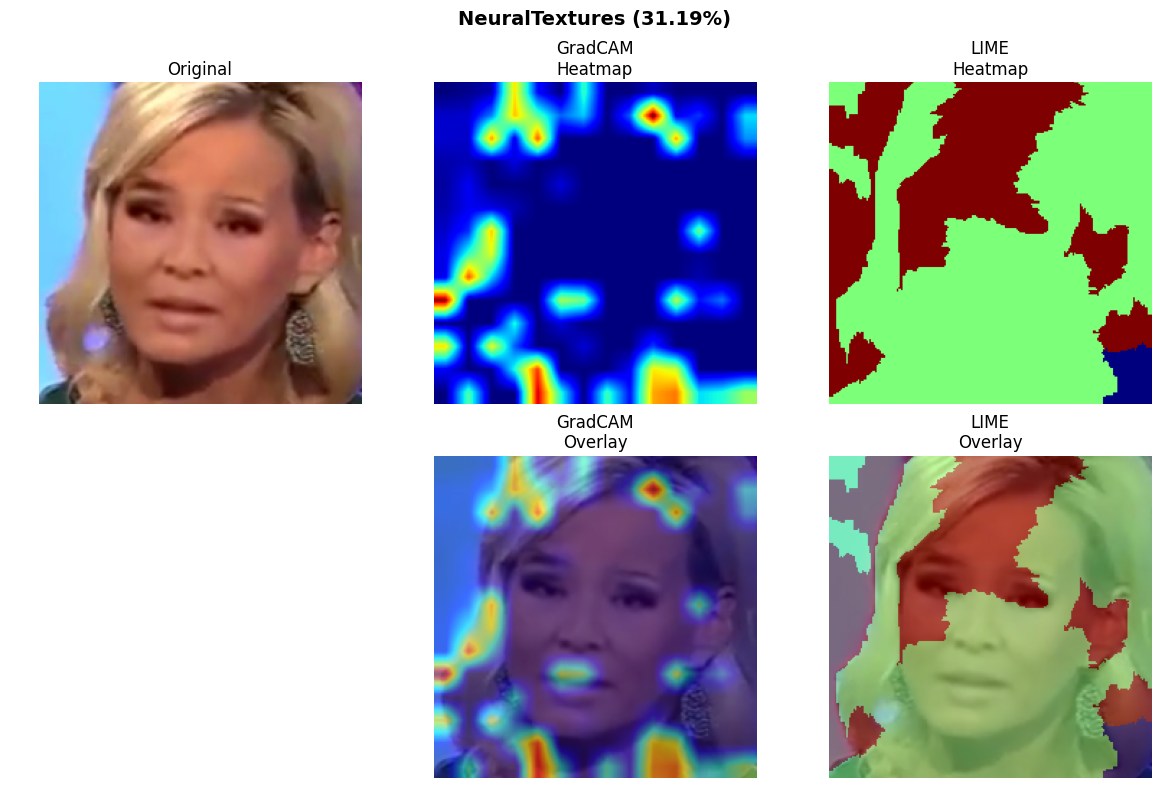


[2/10] Processing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Deepfakes/c23/042_084.mp4/00294_0.png


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to /content/reports/figures/analysis_001.png


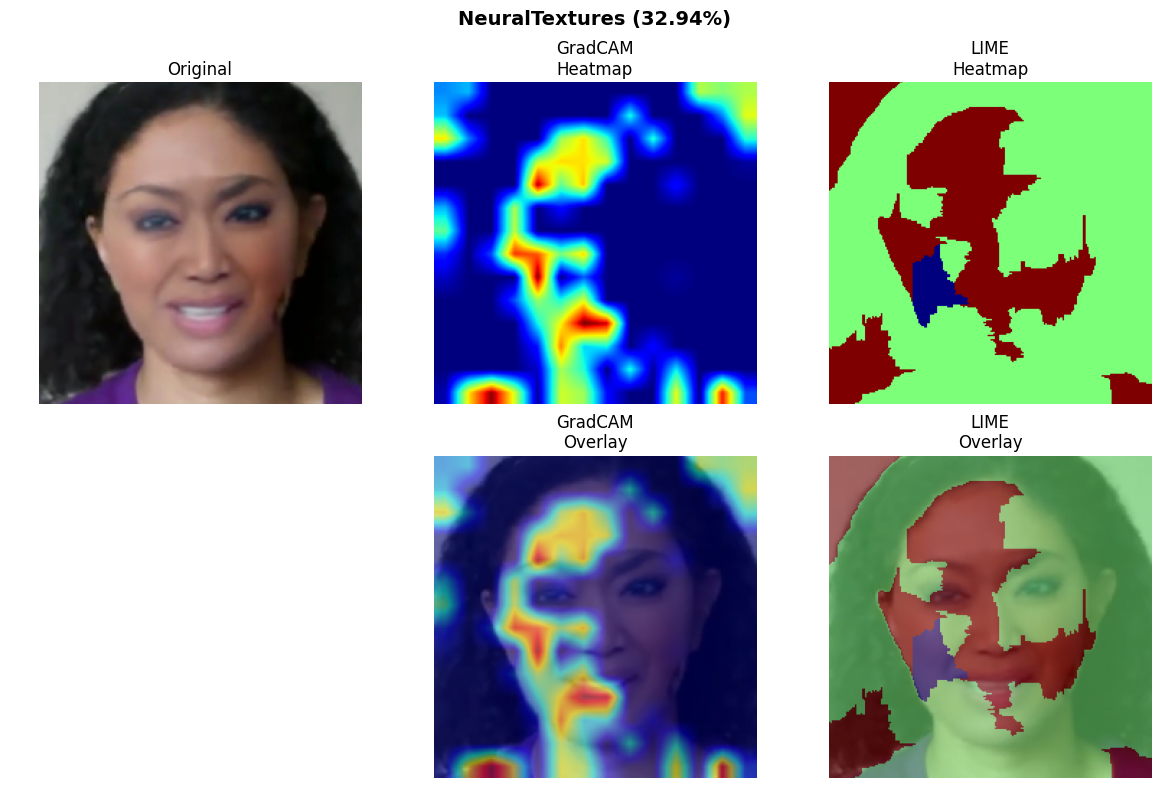


[3/10] Processing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Deepfakes/c23/037_072.mp4/00398_0.png


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to /content/reports/figures/analysis_002.png


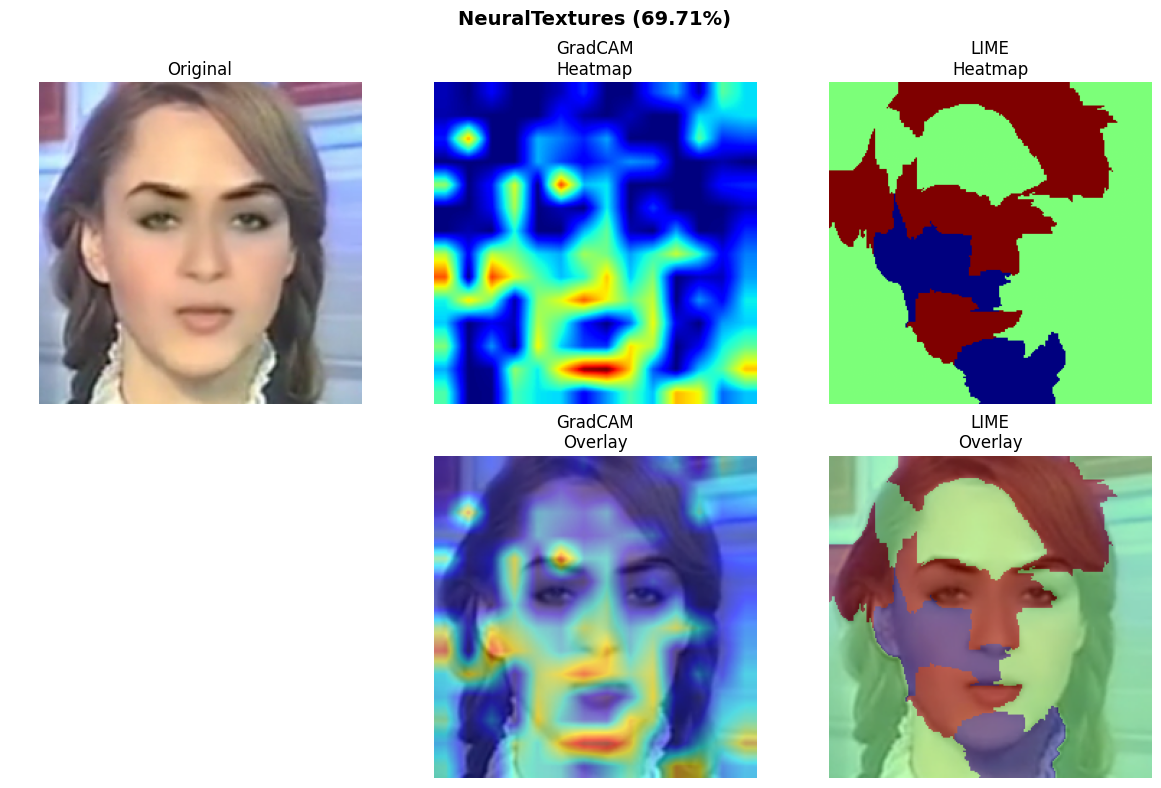


[4/10] Processing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Deepfakes/c23/111_094.mp4/00406_0.png


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to /content/reports/figures/analysis_003.png


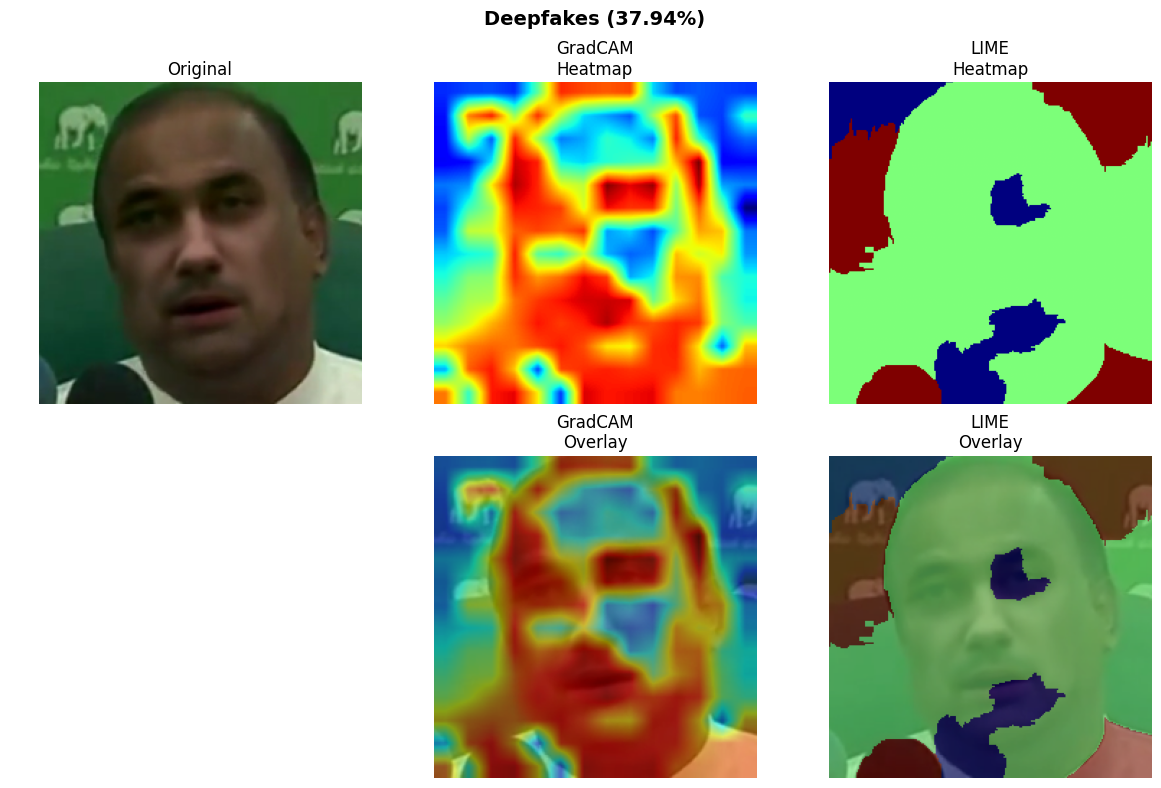


[5/10] Processing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Deepfakes/c23/000_003.mp4/00105_0.png


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to /content/reports/figures/analysis_004.png


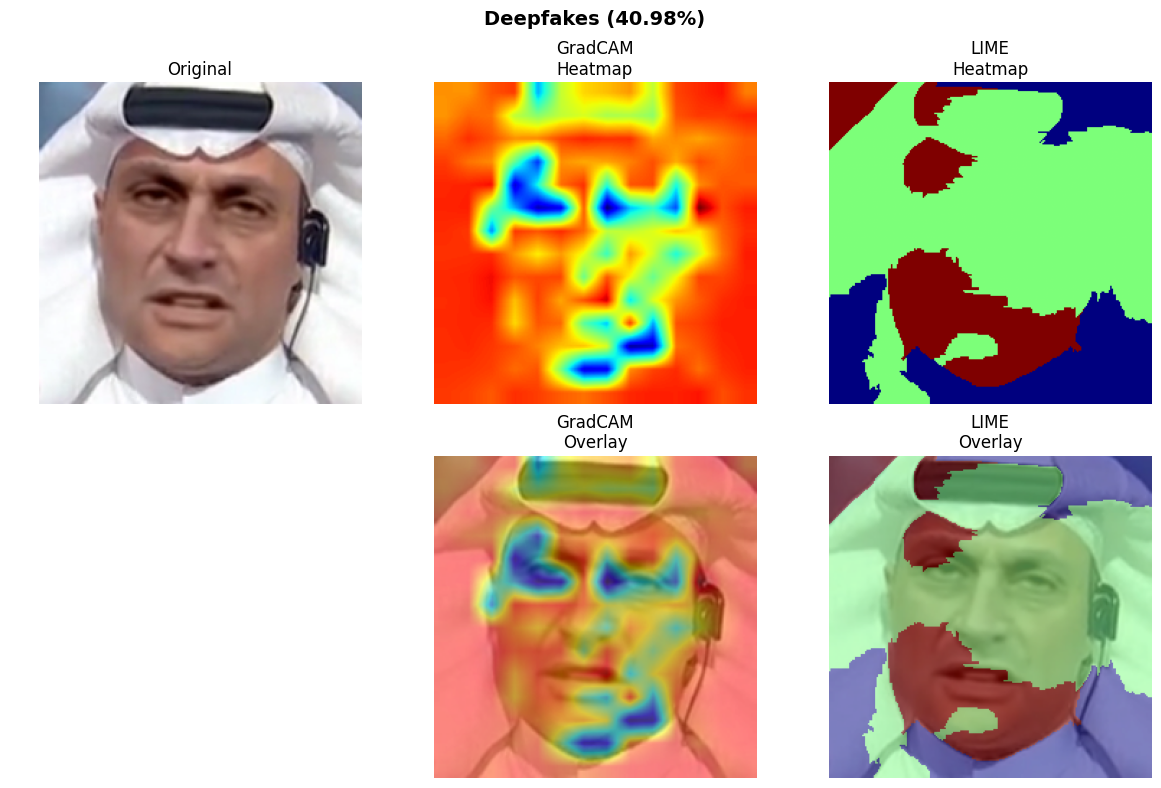


[6/10] Processing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Deepfakes/c23/102_114.mp4/00097_0.png


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to /content/reports/figures/analysis_005.png


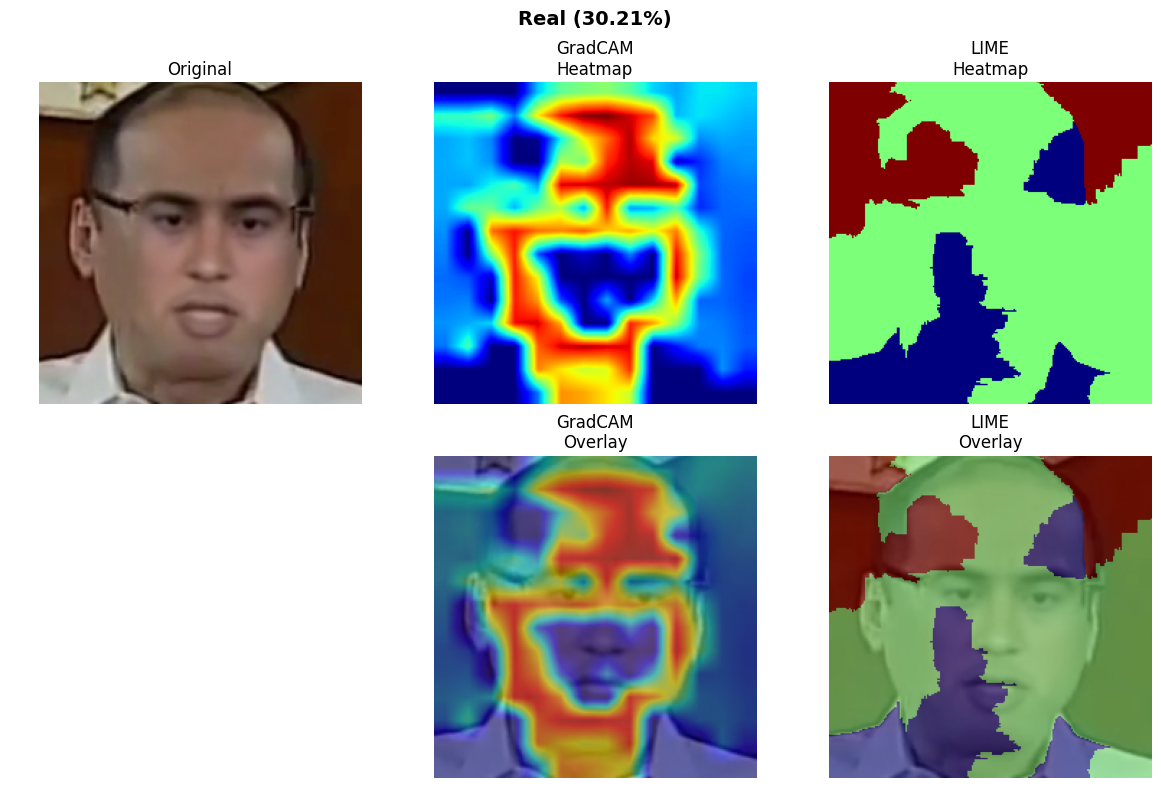


[7/10] Processing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Deepfakes/c23/092_098.mp4/00185_0.png


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to /content/reports/figures/analysis_006.png


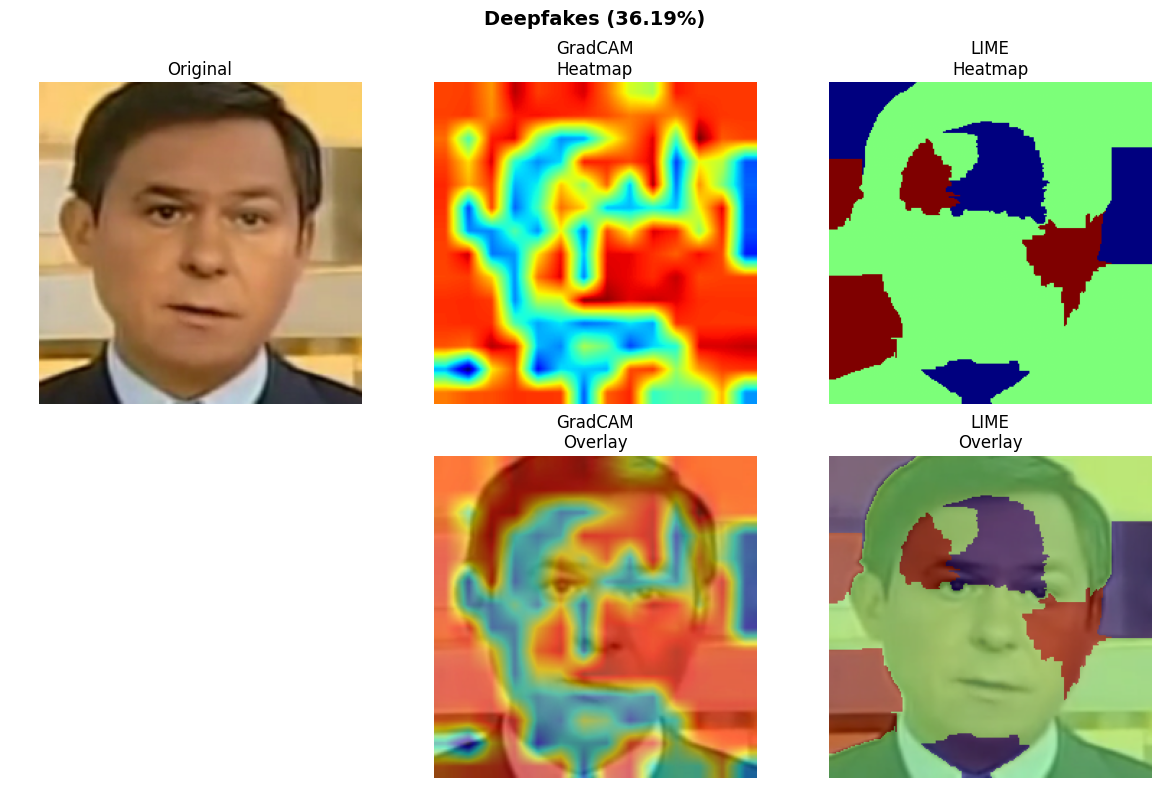


[8/10] Processing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Deepfakes/c23/056_996.mp4/00337_0.png


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to /content/reports/figures/analysis_007.png


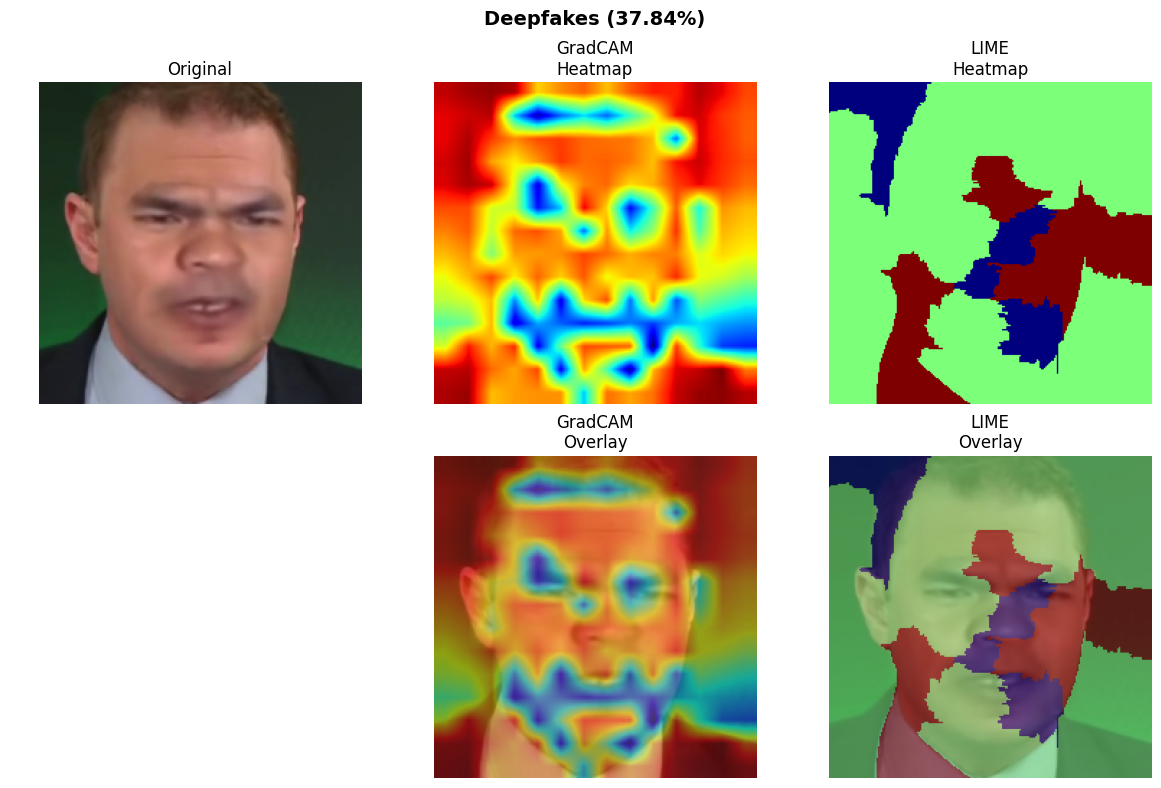


[9/10] Processing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Deepfakes/c23/053_095.mp4/00172_0.png


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to /content/reports/figures/analysis_008.png


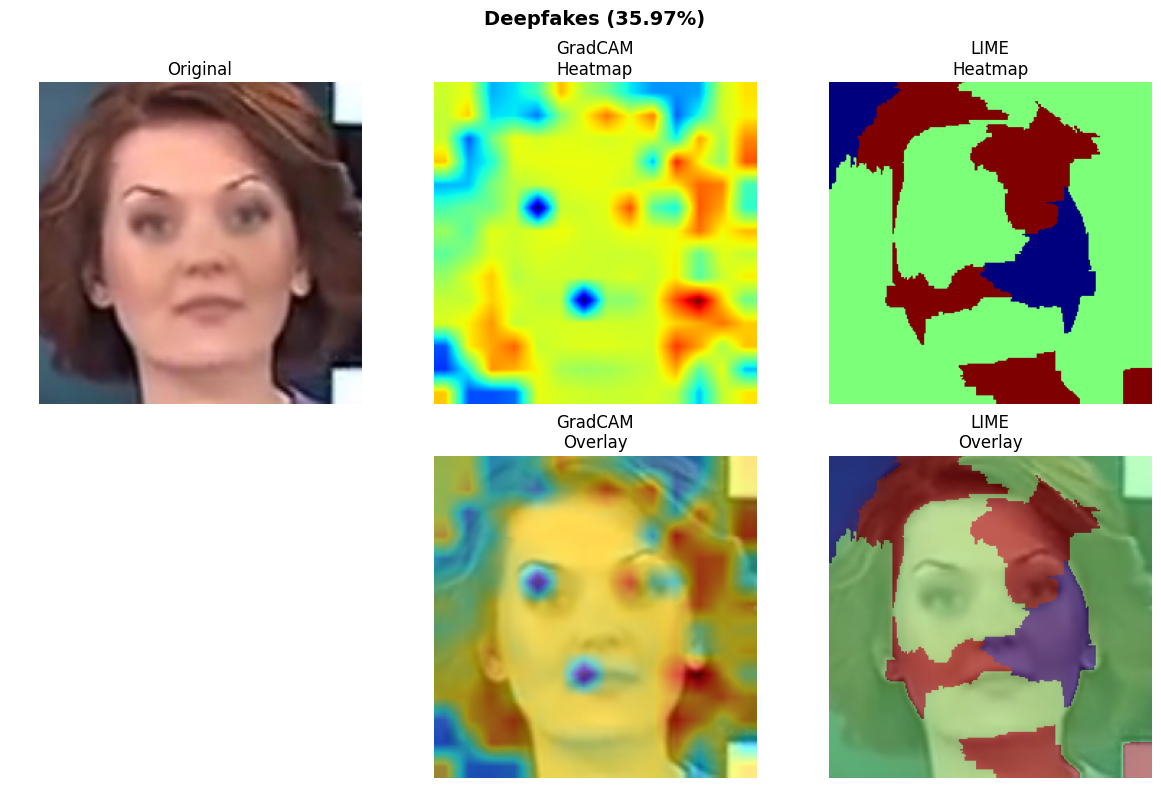


[10/10] Processing: /content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/Deepfakes/c23/086_090.mp4/00826_0.png


  0%|          | 0/500 [00:00<?, ?it/s]

Saved to /content/reports/figures/analysis_009.png


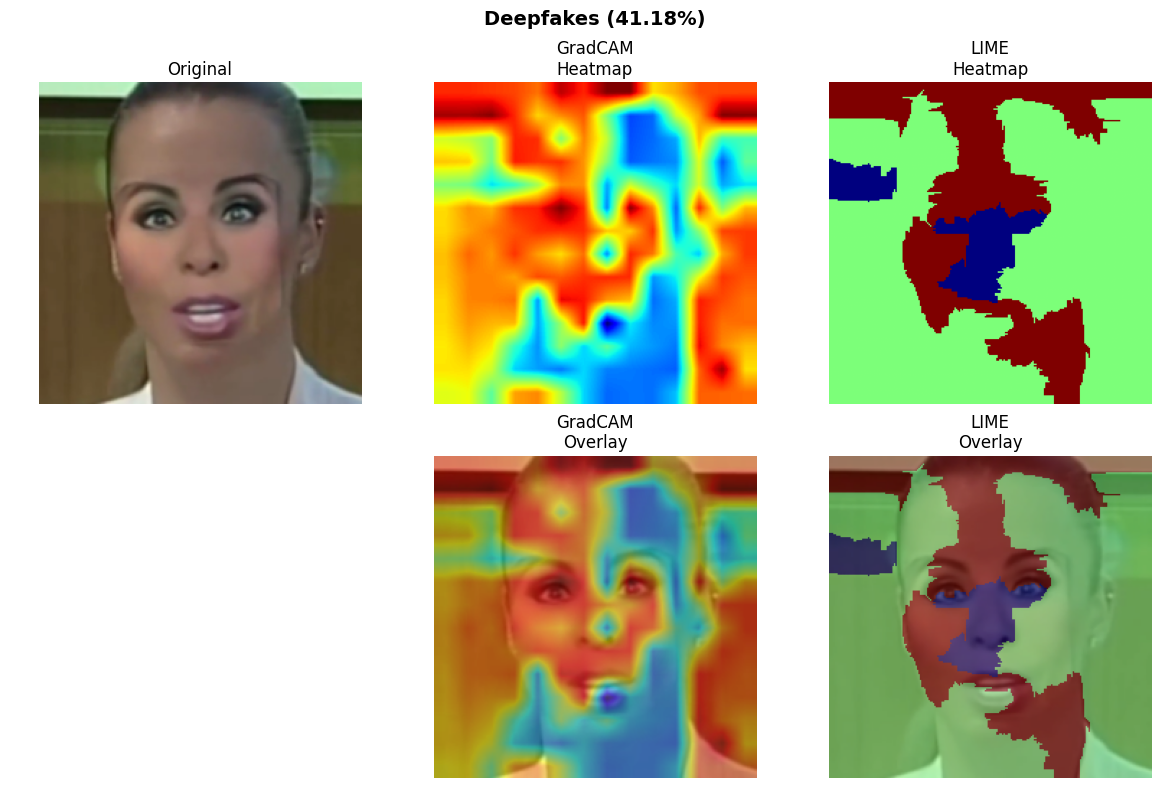


✓ Processed 10 images

BATCH ANALYSIS SUMMARY
Total images: 10
Successfully analyzed: 10
Errors: 0

Prediction Distribution:
  Real: 1 (10.0%)
  Deepfakes: 6 (60.0%)
  Face2Face: 0 (0.0%)
  FaceSwap: 0 (0.0%)
  NeuralTextures: 3 (30.0%)

Confidence Statistics:
  Mean: 0.3942
  Min:  0.3021
  Max:  0.6971
  Std:  0.1070


In [54]:
classes = ["FaceSwap", "Face2Face", "Deepfakes", "NeuralTextures"]
selected_class = 2
print(f"Selected classification class: {classes[selected_class]}")
DATA_PATH = f"/content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences/{classes[selected_class]}/c23"

# list all directories inside data dir and save them to an array
videos_dirs = os.listdir(DATA_PATH)

# select K random videos
num_samples = 10
num_rand_idx = min(num_samples, len(frames_per_video))
video_idx = random.sample(range(len(videos_dirs) - 1), num_rand_idx)

# select one random frame from each video
image_paths = []
for i in range(len(video_idx)):
    frames_per_video = os.listdir(DATA_PATH + "/" + videos_dirs[video_idx[i]])
    frame_idx = random.randint(0, len(frames_per_video) - 1)
    image_paths.append(DATA_PATH + "/" + videos_dirs[video_idx[i]] + "/" + frames_per_video[frame_idx])

results = batch_analyze(image_paths, output_dir=str(PROJECT_ROOT / 'reports/figures'), run_lime=True)
summarize_results(results)

---

## Quick Reference

### Single Image Analysis
```python
results = analyze_image('path/to/image.jpg', run_lime=True)
```

### Batch Analysis
```python
image_paths = ['img1.jpg', 'img2.jpg', 'img3.jpg']
results = batch_analyze(image_paths, output_dir='../reports/figures', run_lime=False)
summarize_results(results)
export_results_to_json(results, '../reports/analysis_results.json')
```

### Manual Explanation
```python
img = load_image('path/to/image.jpg')
input_tensor = preprocess_image(img).to(DEVICE)
heatmap = gradcam_explainer.explain(input_tensor)
plot_single_explanation(denormalize(input_tensor), heatmap)
```


In [53]:
# find total number of frames
import os

manipulated_sequences = "/content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/manipulated_sequences"
total_seq_deepfake, total_seq_face2face, total_seq_faceswap, total_seq_neuraltext = 0, 0, 0, 0

for dir in os.listdir(manipulated_sequences + "/" + "Deepfakes/c23" + "/"):
    for frame in os.listdir(manipulated_sequences + "/" + "Deepfakes/c23" + "/" + dir + "/"):
        total_seq_deepfake += 1
print(f"Number of sequences in Deepfakes: {total_seq_deepfake:,}")

for dir in os.listdir(manipulated_sequences + "/" + "Face2Face/c23" + "/"):
    for frame in os.listdir(manipulated_sequences + "/" + "Face2Face/c23" + "/" + dir + "/"):
        total_seq_face2face += 1
print(f"Number of sequences in Face2Face: {total_seq_face2face:,}")

for dir in os.listdir(manipulated_sequences + "/" + "FaceSwap/c23" + "/"):
    for frame in os.listdir(manipulated_sequences + "/" + "FaceSwap/c23" + "/" + dir + "/"):
        total_seq_faceswap += 1
print(f"Number of sequences in FaceSwap: {total_seq_faceswap:,}")

for dir in os.listdir(manipulated_sequences + "/" + "NeuralTextures/c23" + "/"):
    for frame in os.listdir(manipulated_sequences + "/" + "NeuralTextures/c23" + "/" + dir + "/"):
        total_seq_neuraltext += 1
print(f"Number of sequences in NeuralTextures: {total_seq_neuraltext:,}")


total_seq = total_seq_deepfake + total_seq_face2face + total_seq_faceswap + total_seq_neuraltext
print(f"Total number of frames: {total_seq:,}")


Number of sequences in Deepfakes: 48,091
Number of sequences in Face2Face: 64,105
Number of sequences in FaceSwap: 50,778
Number of sequences in NeuralTextures: 26,954
Total number of frames: 189,928


In [27]:
original_sequences = "/content/drive/MyDrive/NYU/fall-25/advanced-cv/forensicbind/FFPP_processed/original_sequences"
total_seq_original = 0

for dir in os.listdir(original_sequences + "/" + "c23" + "/"):
    for frame in os.listdir(original_sequences + "/" + "c23" + "/" + dir + "/"):
        total_seq_original += 1

print(f"Number of sequences in original: {total_seq_original:,}")

Number of sequences in original: 30,789
